In [1]:
import sys
import os
import numpy as np
import torch
import pandas as pd
import csv
from scipy.stats import binom
from sklearn.metrics import roc_auc_score
import torch.nn as nn
import math

In [2]:
# custom imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from src.utils import load_config
import src.graphs_generation as graphs_gen

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\danie\Desktop\Virtual Envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model definition

## Common functions

Functions adapted from:
`\HUPLACLIP-NNs\scripts\visualizations\degree_distribution.ipynb`

In [3]:
def p_correction(p_nodes, graph_size, clique_size):
    '''Returns the value of the corrected p-value in the graph with clique ("p_reduce" case) '''
    p_corrected = (
        p_nodes * graph_size * (graph_size - 1)
        - clique_size * (clique_size - 1)
    ) / ((graph_size - clique_size) * (graph_size + clique_size - 1))
    return p_corrected

# P(d|C=0)
def p_noclique(degree_arr, graph_size):
    ''' 
    For an array of degree values (degree_arr: ndarray of shape [N_graphs, 1, graph_size]), returns the probability that (in a graph WITHOUT the clique) a node has exactly that degree.    
    Returns: ndarray of probabilities, same shape as degree_arr
    '''
    return binom.pmf(degree_arr, 
                     graph_size-1, 
                     0.5    # "p_reduce" correction only acts on graph with clique
                     )

def expected_count_noclique(degree_arr, graph_size):
    '''
    Uses p_noclique to obtain the number of nodes that (in a graph WITHOUT the clique) are expected to have exactly that degree.
    '''
    # expected count = graph_size * probability_per_node
    return graph_size * p_noclique(degree_arr, graph_size)

# P(d|C=1)
def p_ingroup(degree_arr, graph_size, clique_size, p_corrected):
    ''' 
    For an array of degree values (degree_arr: ndarray of shape [N_graphs, 1, graph_size]), returns the probability that (in a graph WITH the clique) a node INSIDE the clique has exactly that degree.    
    Returns: ndarray of probabilities, same shape as degree_arr
    '''
    return binom.pmf(degree_arr - (clique_size-1),  # number of non-clique connections
                     graph_size - clique_size,      # number of possible non-clique nodes
                     p_corrected
                     )

def p_outgroup(degree_arr, graph_size, clique_size, p_corrected):
    ''' 
    For an array of degree values (degree_arr: ndarray of shape [N_graphs, 1, graph_size]), returns the probability that (in a graph WITH the clique) a node OUTSIDE the clique has exactly that degree.    
    Returns: ndarray of probabilities, same shape as degree_arr
    '''
    return binom.pmf(degree_arr, 
                     graph_size-1, 
                     p_corrected
                     )

def expected_count_clique(degree_arr, graph_size, clique_size, p_corrected):
    '''Combines p_outgroup and p_ingroup (single mixture) to obtain the number of nodes that (in a graph WITH the clique) are expected to have exactly that degree'''
    prob = clique_size/graph_size * p_ingroup(degree_arr, graph_size, clique_size, p_corrected) + (1-clique_size/graph_size) * p_outgroup(degree_arr, graph_size, clique_size, p_corrected)    
    # expected count = graph_size * probability_per_node
    prob = graph_size * prob
    return prob

## Architecture diagrams

"Ideal MLP" designed starting from this initial sketch (11/11/2025):

![Alt text](../../scripts/Ideal-MLP_performance/whiteboard_images/Ideal-MLP-sketch.jpg)

More complete diagram (17/11/2025):

![Alt text](../../scripts/Ideal-MLP_performance/whiteboard_images/Zoom-Meeting_2025-11-17_Ideal-MLP_architecture.png)

![Alt text](../../scripts/Ideal-MLP_performance/whiteboard_images/Ideal-MLP-sketch_II.jpg)

## "Function" implementation

Here we design the Ideal MLP as an input/output function, to check that the resolution strategy works correctly. It includes both the "k-known" and "k-not-known" cases.

In [4]:

class Ideal_MLP(nn.Module):
    
    # NOTE possible improvements:
    # - handle with actual bins (now n_bins = N)
    # - standardization before comparing clique/no clique
    # - "left" and "right" blocks can be simplified?
    
    def __init__(self, graph_size:int, max_clique_prop:float = 0.7, k_known:bool = False):
        super().__init__()
        self.graph_size = torch.tensor(graph_size, dtype=torch.int32)
        self.k_known = k_known
        
        # Precomputing variables:
        print("Precomputing variables...")
        # - array of bin edges: 
        self.tau = torch.arange(0, self.graph_size+1) #NOTE: possible improvement is extending this to actual bins spanning more than 1 single value
        #print("Tau values: ", self.tau)
        # - array of clique size values:
        max_K = int(max_clique_prop * self.graph_size)
        stat_lim = round(2 * math.log2(self.graph_size))
        # if K-not-known, consider clique size values only down to stat limit (to reduce "no clique" bias)
        if(self.k_known):
            self.clique_size_values = torch.arange(1, max_K + 1)  
        else:
            self.clique_size_values = torch.arange(stat_lim, max_K + 1)
            
        print("Clique size values: ", self.clique_size_values)
        # - compute expected histograms and store as torch.float32 tensors
        # -- no clique
        self.expected_hist_no_clique = torch.tensor(
            expected_count_noclique(self.tau, self.graph_size), dtype=torch.float32
        )  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts
        self.expected_hist_no_clique_std = torch.sqrt(self.graph_size * (self.expected_hist_no_clique / self.graph_size) * ( 1 - self.expected_hist_no_clique / self.graph_size)).clamp(min=1e-6)
        expected_hist_clique = []
        expected_hist_clique_std = []
        # -- clique (calculating expected histogram for all possible clique size values)
        for K in self.clique_size_values:
            p_corrected = p_correction(0.5, self.graph_size, K)
            expected_hist_K = torch.tensor(expected_count_clique(self.tau, self.graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts
            expected_hist_clique.append(expected_hist_K)
            expected_hist_K_std = torch.sqrt(self.graph_size * (expected_hist_K / self.graph_size) * (1 - expected_hist_K / self.graph_size) ).clamp(min=1e-6)
            expected_hist_clique_std.append(expected_hist_K_std)
        self.expected_hist_clique = torch.stack(expected_hist_clique, dim=1)  # shape: (len_tau, len_clique_size_values) 
        self.expected_hist_clique_std = torch.stack(expected_hist_clique_std, dim=1)  # shape: (len_tau, len_clique_size_values) 
        print("Completed precomputing variables...")
        
    # Processing blocks:
    def forward(self, adj_matrices: torch.Tensor, clique_size: int = None):
        '''
        Input: adj_matrices of shape [batch_size, 1, N, N]
        Optional input: clique_size (int) - if provided, use that single clique size's expected histogram
        Output: tensor of shape [batch_size] (probability of "clique")
        '''
        if(adj_matrices.shape[2] != self.graph_size):
            raise ValueError(f"Input graphs have size {adj_matrices.shape[2]}, but model was initialized for size {self.graph_size}")
                    
        # if model expects a known K, require it be passed
        if self.k_known and clique_size is None:
            raise ValueError("Model was initialized with k_known=True but no clique_size was provided to forward().")

        # compute degree of each node (sum over rows)
        degrees = torch.sum(adj_matrices, dim=2)  # shape: (batch_size, 1, N)
        degrees = degrees.squeeze(1)  # shape: (batch_size, N)
        
        # Vectorized: degrees shape (batch_size, N)
        batch_size, N = degrees.shape
        len_tau = len(self.tau)

        # cast tau to same dtype/device and reshape for broadcasting:
        tau_val = self.tau.to(dtype=degrees.dtype, device=degrees.device).view(1, len_tau, 1)  # shape: (1, len_tau, 1)
        deg_batched = degrees.view(batch_size, 1, N)  # shape: (batch_size, 1, N)

        # "left" block (broadcasts to (batch_size, len_tau, N))
        x_left = torch.relu(deg_batched - (tau_val - 2.0))
        x_left = torch.relu(2.0 - x_left)
        left = x_left - torch.relu(x_left - 1.0)

        # "right" block (broadcasts to (batch_size, len_tau, N))
        x_right = torch.relu(deg_batched - (tau_val - 1.0))
        x_right = torch.relu(2.0 - x_right)
        right = x_right - torch.relu(x_right - 1.0)

        # indicator matrix per graph: (batch_size, len_tau, N)
        degree_indicator_matrices = (right - left)  # float tensor with 0/1 values

        # summing over nodes to get raw histograms:
        raw_histograms = degree_indicator_matrices.sum(dim=2)  # shape (batch_size, len_tau)
        
        # computing differences with expected histograms:
        # - no clique case:
        expected_no_clique = self.expected_hist_no_clique.to(dtype=degrees.dtype, device=degrees.device).view(1, len_tau)  # shape: (1, len_tau)
        expected_no_clique_std = self.expected_hist_no_clique_std.to(dtype=degrees.dtype, device=degrees.device).view(1, len_tau)  # shape: (1, len_tau)
        if(self.k_known):
            # stable without standardization
            diff_no_clique = torch.abs(raw_histograms - expected_no_clique)  # shape: (batch_size, len_tau)
        else:
            # Alternatives:
            # - no standardization:
            diff_no_clique = torch.abs(raw_histograms - expected_no_clique)  # shape: (batch_size, len_tau)            
            # # - standardization:
            # safe_std_no_clique = expected_no_clique_std.clamp(min=1e-6)
            # diff_no_clique = torch.abs(raw_histograms - expected_no_clique) /safe_std_no_clique  # shape: (batch_size, len_tau)          
        mean_diff_no_clique = diff_no_clique.mean(dim=1)  # shape: (batch_size,)  
        
        print("Mean diff no clique:")
        print(mean_diff_no_clique)

        # - clique case:
        # prepare expected_clique depending on provided clique_size
        if self.k_known:
            k_val = int(clique_size)
            k_list = [int(x) for x in self.clique_size_values.tolist()]
            if k_val not in k_list:
                raise ValueError(f"Provided clique_size={k_val} is not in precomputed clique_size_values: {k_list}")
            idx = k_list.index(k_val)
            # pick single-column expected histogram and shape to (1, len_tau, 1)
            expected_clique = self.expected_hist_clique[:, idx].to(dtype=degrees.dtype, device=degrees.device).unsqueeze(0).unsqueeze(2)
        else:
            # use all precomputed Ks and average over them later; shape -> (1, len_tau, num_K)
            expected_clique = self.expected_hist_clique.to(dtype=degrees.dtype, device=degrees.device).unsqueeze(0)
            expected_clique_std = self.expected_hist_clique_std.to(dtype=degrees.dtype, device=degrees.device).unsqueeze(0)

        # compute differences per K (or single K)
        raw_expanded = raw_histograms.unsqueeze(2)  # (batch_size, len_tau, 1)
        if(self.k_known):
            diff_clique_per_tau = torch.abs(raw_expanded - expected_clique)  # (batch_size, len_tau, 1)
            mean_diff_clique = diff_clique_per_tau.mean(dim=1).squeeze()  # (batch_size,)            
        else:
            # Alternatives:
            # # - no standardization, calculating average diff across K values
            # print("No standardization, average diff across K")
            # diff_clique_per_tau = torch.abs(raw_expanded - expected_clique)  # (batch_size, len_tau, num_K)
            # diff_clique_per_K = diff_clique_per_tau.mean(dim=1)  # (batch_size, num_K)
            # mean_diff_clique = diff_clique_per_K.mean(dim=1).squeeze()  # (batch_size,)                               
            # # - standardization, calculating average diff across K values
            # print("Standardization, average diff across K")
            # safe_std_clique = expected_clique_std.clamp(min=1e-6)        
            # diff_clique_per_tau = torch.abs(raw_expanded - expected_clique) / safe_std_clique  # (batch_size, len_tau, num_K)            
            # diff_clique_per_K = diff_clique_per_tau.mean(dim=1)  # (batch_size, num_K)
            # mean_diff_clique = diff_clique_per_K.mean(dim=1).squeeze()  # (batch_size,)               
            # - no standardization, selecting K value with smallest difference
            print("No standardization, average diff for K value with smallest difference")
            diff_clique_per_tau = torch.abs(raw_expanded - expected_clique)  # (batch_size, len_tau, num_K)
            diff_clique_per_K = diff_clique_per_tau.mean(dim=1)  # (batch_size, num_K)
            mean_diff_clique = torch.min(diff_clique_per_K, dim=1).values  # (batch_size,)             
            # # - standardization, selecting K value with smallest difference
            # print("Standardization, average diff for K value with smallest difference")
            # safe_std_clique = expected_clique_std.clamp(min=1e-6)        
            # diff_clique_per_tau = torch.abs(raw_expanded - expected_clique) / safe_std_clique  # (batch_size, len_tau, num_K)            
            # diff_clique_per_K = diff_clique_per_tau.mean(dim=1)  # (batch_size, num_K)
            # mean_diff_clique = torch.min(diff_clique_per_K, dim=1).values  # (batch_size,)                   
            # Other possibilities:
            # - deriving decision criterion directly only from "no-clique" differences (ignoring "clique" ones)               
            # - median diff across K values
            
        print("Mean diff clique:")
        print(mean_diff_clique)

        if self.k_known:
            # -"K-known" case: "no-clique" - "clique" (smaller difference -> more likely that class)    
            soft_output = torch.sigmoid(mean_diff_no_clique - mean_diff_clique)  # probability of "clique" per graph  
            hard_output =  (mean_diff_clique < mean_diff_no_clique).float()
        else:  
            soft_output = torch.sigmoid(mean_diff_no_clique - mean_diff_clique)  # probability of "clique" per graph  
            hard_output =  (mean_diff_clique < mean_diff_no_clique).float()        
                    
            # -TODO ("K-not-known") case: establish criterion only based on "no-clique" differences, centering it around 0
        
        # Visualization of empirical histogram if first graph of the batch and expected counts       
        import matplotlib.pyplot as plt
        # convert tensors to numpy arrays
        raw_vec = raw_histograms[0].detach().cpu().numpy()
        # no clique case
        expected_no_np = expected_no_clique.squeeze(0).detach().cpu().numpy()  # (len_tau,)
        mean_no = expected_no_np.astype(float)
        std_no = torch.sqrt(self.graph_size * (mean_no / self.graph_size) * (1.0 - mean_no / self.graph_size)).numpy()
        plt.figure(figsize=(8,3))
        plt.plot(raw_vec, label="empirical (first graph)", color="k")
        plt.plot(mean_no, label="expected (no-clique)", color="C0")
        plt.fill_between(np.arange(mean_no.shape[0]), mean_no - std_no, mean_no + std_no, color="C0", alpha=0.4)
        # clique case: handle k_known or multiple Ks (pick best K for first graph)
        exp_clq = expected_clique  # shape: (1, len_tau, num_K)
        if clique_size is not None:
            k_list = [int(x) for x in self.clique_size_values.tolist()]
            clique_idx = k_list.index(int(clique_size))
            expected_clique_np = exp_clq[0, :, 0].detach().cpu().numpy()            
        else:
            clique_idx = int(torch.argmin(diff_clique_per_K[0]).item())
            expected_clique_np = exp_clq[0, :, clique_idx].detach().cpu().numpy()
        mean_clique = expected_clique_np.astype(float)
        std_clique = torch.sqrt(self.graph_size * (mean_clique / self.graph_size) * (1.0 - mean_clique / self.graph_size)).numpy()
        plt.plot(mean_clique, label=f"expected (clique K={self.clique_size_values[clique_idx]}{', best K' if not self.k_known else ''})", color="C1")
        plt.fill_between(np.arange(mean_clique.shape[0]), mean_clique - std_clique, mean_clique + std_clique, color="C1", alpha=0.4)
        plt.title("K known" if self.k_known else "K not known")
        plt.xlim(0, len(self.tau))
        plt.legend(fontsize=9)
        plt.tight_layout()
        plt.xlim(self.graph_size*0.3, self.graph_size*0.7)
        plt.show()

        return soft_output, hard_output
    

Clique size of:  240  in a graph of size:  1200


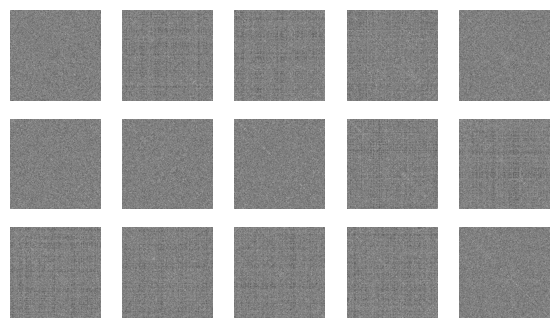

K-not-known case: 
Precomputing variables...
Clique size values:  tensor([ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
         34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
         48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
         62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
        146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
        174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187

C:\Users\danie\AppData\Local\Temp\ipykernel_30604\57135594.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.expected_hist_no_clique = torch.tensor(
C:\Users\danie\AppData\Local\Temp\ipykernel_30604\57135594.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_K = torch.tensor(expected_count_clique(self.tau, self.graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts


Completed precomputing variables...
Mean diff no clique:
tensor([0.2181, 1.1351, 1.1823, 1.2018, 0.2086, 0.2066, 0.2022, 0.2449, 1.1391,
        1.1351, 1.1698, 1.1464, 1.1746, 1.1995, 0.1842])
No standardization, average diff for K value with smallest difference
Mean diff clique:
tensor([0.2121, 0.2550, 0.2845, 0.2603, 0.2044, 0.2067, 0.2024, 0.2451, 0.3016,
        0.2903, 0.2714, 0.2353, 0.2601, 0.2872, 0.1846])


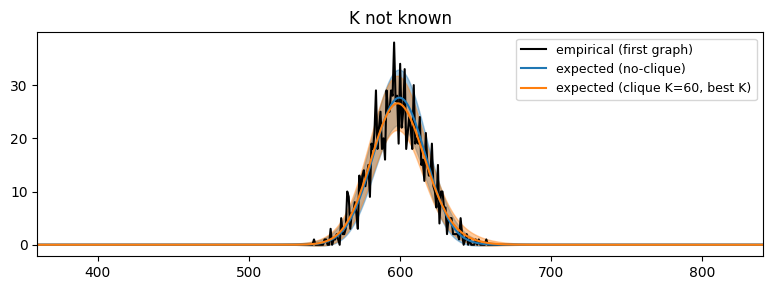

||Soft outputs: tensor([0.5015, 0.7069, 0.7105, 0.7194, 0.5011, 0.5000, 0.5000, 0.4999, 0.6979,
        0.6995, 0.7106, 0.7132, 0.7139, 0.7135, 0.4999])
||Hard outputs:  tensor([1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0.])
||Labels:  [0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
||Fraction of correct responses:
0.8666666666666667


In [6]:
import matplotlib.pyplot as plt

# test of model on task instance
N_value = 1200   #CHANGE THIS
clique_size_fraction = 0.2 # CHANGE THIS
print("Clique size of: ", int(clique_size_fraction*N_value), " in a graph of size: ", N_value)
# visualizing input for 15 graphs, "p_reduce"
graphs_with_clique = graphs_gen.generate_batch(15, N_value, np.repeat([int(clique_size_fraction*N_value)],15), "p_reduce", False)
# Show 15 graphs
fig, axes = plt.subplots(3, 5, figsize=(7, 4))
for i in range(15):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(np.squeeze(graphs_with_clique[0][i]), cmap='gray_r')
    axes[row, col].axis('off')
plt.show()
# # testing ideal MLP on this graph:
# print("K-known case: ")
# ideal_MLP = Ideal_MLP(N_value, k_known = True)
# soft_output, hard_output = ideal_MLP(graphs_with_clique[0], int(clique_size_fraction*N_value))
# hard_output_np = hard_output.cpu().numpy().astype(int)
# labels_np = np.array(graphs_with_clique[1], dtype=int)
# print("||Soft outputs:", soft_output)
# print("||Hard outputs: ", hard_output)
# print("||Labels: ", graphs_with_clique[1])
# print("||Fraction of correct responses:")
# print(np.sum(hard_output_np == labels_np) / 15)

print("K-not-known case: ")
ideal_MLP = Ideal_MLP(N_value)
soft_output, hard_output = ideal_MLP(graphs_with_clique[0])
hard_output_np = hard_output.cpu().numpy().astype(int)
labels_np = np.array(graphs_with_clique[1], dtype=int)
print("||Soft outputs:", soft_output)
print("||Hard outputs: ", hard_output)
print("||Labels: ", graphs_with_clique[1])
print("||Fraction of correct responses:")
print(np.sum(hard_output_np == labels_np) / 15)

## Test

In [ ]:
# read configuration file:
config = load_config(
    os.path.join("Ideal-MLP_test_config.yml")
)  # CHANGE THIS TO PERFORM DIFFERENT EXPERIMENTS

# looping over the models to be tested:
for model in config["models"]:
    
    # looping over the different graph sizes in the experiment:
    for graph_size in config["graph_size_values"]:
        
        if("not" in model["model_name"]):
            ideal_MLP = Ideal_MLP(graph_size).to(device)
        else:
            ideal_MLP = Ideal_MLP(graph_size, k_known=True).to(device)

        # Create empty dictionaries for storing testing results:
        fraction_correct_results = {}  # Fraction correct for each clique size
        metrics_results_list = []

        # Calculate max clique size for testing (proportion of graph size):
        max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"]
        max_clique_size = int(
            max_clique_size_proportion_test * graph_size
        )

        # Calculate array of clique sizes for all test curriculum
        # NOTE: if max clique size is smaller than the the number of test levels, use max clique size as the number of test levels
        clique_sizes = np.linspace(
            max_clique_size,
            1,
            num=min(max_clique_size, config["testing_parameters"]["clique_testing_levels"]),
        ).astype(int)
        
        # Metrics initialization
        TP, FP, TN, FN = 0, 0, 0, 0  
        y_scores = []
        y_true = []    

        # Loop for decreasing clique sizes
        for current_clique_size in clique_sizes:

            # Initialize fraction correct list, updated at each test iteration
            fraction_correct_list = []

            # Loop for testing iterations:
            for test_iter in range(config["testing_parameters"]["test_iterations"]):

                # Generate clique size value of each graph in the current batch
                clique_size_array_test = graphs_gen.generate_batch_clique_sizes(
                    np.array([current_clique_size]),
                    config["testing_parameters"]["num_test"],
                )

                # Generate validation graphs
                test = graphs_gen.generate_batch(
                    config["testing_parameters"]["num_test"],
                    graph_size,
                    clique_size_array_test,
                    config["p_correction_type"],
                    False,
                )
                
                # Perform prediction on test data
                if("not" in model["model_name"]):
                    soft_output, hard_output = ideal_MLP(test[0])
                else:
                    soft_output, hard_output = ideal_MLP(test[0], current_clique_size)
                    
                # print(hard_output.shape, test_labels.shape)   # DEBUGGING

                # Update global metrics for AUC-ROC
                y_scores.extend(soft_output.cpu().tolist())
                labels = test[1]
                y_true.extend(list(labels))
                
                # transforming test_labels to torch tensors:
                test_labels = torch.tensor(test[1], dtype=torch.float32)
                
                # # DEBUGGING:
                # print("Soft outputs: ", soft_output)
                # print("Hard outputs: ", hard_output)
                # print("Test labels: ", test_labels)
                
                # Compute metrics
                TP += ((hard_output == 1) & (test_labels == 1)).sum().item()
                FP += ((hard_output == 1) & (test_labels == 0)).sum().item()
                TN += ((hard_output == 0) & (test_labels == 0)).sum().item()
                FN += ((hard_output == 0) & (test_labels == 1)).sum().item()

                # updating fraction correct list with the accuracy of the current test iteration:
                fraction_correct_list.append(
                    (hard_output == test_labels).sum().item()
                    / (1.0 * config["testing_parameters"]["num_test"])
                )
                
                # delete unused variables
                del test, hard_output, test_labels, clique_size_array_test, soft_output
                torch.cuda.empty_cache()

            # Updating dictionary after all test iterations for current clique size have been completed:
            fraction_correct_results[current_clique_size] = round(
                sum(fraction_correct_list) / len(fraction_correct_list), 2
            )

            # Printing the size of the clique just tested and the corresponding test accuracy:
            print(
                f"||| Completed testing for clique = {current_clique_size}. "
                f"Average fraction correct = {fraction_correct_results[current_clique_size]}"
            )
            print("|||===========================================================")

        # - notify completion of testing:
        label = 'K not known' if "not" in model["model_name"] else 'K known'
        print(f"| Finished testing Ideal MLP ({label}) at N = {graph_size}.")        

        # Computing metrics:
        precision = TP / (TP + FP + 1e-10)
        recall = TP / (TP + FN + 1e-10)
        F1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        AUC_ROC = roc_auc_score(y_true, y_scores)
        num_params = sum(
            p.numel() for p in ideal_MLP.parameters()
        )  # storing total number of parameters
        metrics_results = {
            "TP": TP,
            "FP": FP,
            "TN": TN,
            "FN": FN,
            "precision": precision,
            "recall": recall,
            "F1": F1,
            "AUC_ROC": AUC_ROC,
            "total_params": num_params,
        }

        # Saving accuracy results in .csv file:
        model_label = 'k-not-known' if "not" in model["model_name"] else 'k-known'
        # - defining file name and path:
        file_path = os.path.join(
            os.getcwd(), "results", "k-not-known", "no-stand_avg-k", f"Ideal-MLP_{model_label}_avg-k_N{graph_size}_fraction_correct.csv"
        )
        # - saving the dictionary as a .csv file:
        with open(file_path, "w") as file:
            writer = csv.writer(file)
            writer.writerow(["clique size", "fraction correct"])  # Add column labels
            for key, value in fraction_correct_results.items():
                writer.writerow([key, value])
        # Saving metrics results in .csv file:
        # - defining file name and path:
        file_path = os.path.join(
            os.getcwd(), "results", "k-not-known", "no-stand_avg-k", f"Ideal-MLP_{model_label}_avg-k_N{graph_size}_metrics.csv"
        )
        # - saving the dictionary as a .csv file:
        pd.DataFrame([metrics_results]).to_csv(file_path, index=False)

        print(f"- Ideal MLP ({label}) results saved successfully for N = {graph_size}.")

Configuration file loaded successfully.
Precomputing variables...
Clique size values:  tensor([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
        31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70])
Completed precomputing variables...
||| Completed testing for clique = 70. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 69. Average fraction correct = 1.0
|||===========================================================


C:\Users\danie\AppData\Local\Temp\ipykernel_3560\2672930077.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.expected_hist_no_clique = torch.tensor(
C:\Users\danie\AppData\Local\Temp\ipykernel_3560\2672930077.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_K = torch.tensor(expected_count_clique(self.tau, self.graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts


||| Completed testing for clique = 68. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 67. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 66. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 65. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 64. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 63. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 62. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 61. Average fraction correct = 1.0

C:\Users\danie\AppData\Local\Temp\ipykernel_3560\2672930077.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.expected_hist_no_clique = torch.tensor(
C:\Users\danie\AppData\Local\Temp\ipykernel_3560\2672930077.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_K = torch.tensor(expected_count_clique(self.tau, self.graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts


||| Completed testing for clique = 103. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 102. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 101. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 100. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 99. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 98. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 97. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 96. Average fraction correct =

C:\Users\danie\AppData\Local\Temp\ipykernel_3560\2672930077.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.expected_hist_no_clique = torch.tensor(
C:\Users\danie\AppData\Local\Temp\ipykernel_3560\2672930077.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_K = torch.tensor(expected_count_clique(self.tau, self.graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts


Completed precomputing variables...
||| Completed testing for clique = 140. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 138. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 137. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 135. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 134. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 132. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 131. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for 

C:\Users\danie\AppData\Local\Temp\ipykernel_3560\2672930077.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.expected_hist_no_clique = torch.tensor(
C:\Users\danie\AppData\Local\Temp\ipykernel_3560\2672930077.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_K = torch.tensor(expected_count_clique(self.tau, self.graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts


Completed precomputing variables...
||| Completed testing for clique = 210. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 207. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 205. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 203. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 201. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 199. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 197. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for 

C:\Users\danie\AppData\Local\Temp\ipykernel_3560\2672930077.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.expected_hist_no_clique = torch.tensor(
C:\Users\danie\AppData\Local\Temp\ipykernel_3560\2672930077.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_K = torch.tensor(expected_count_clique(self.tau, self.graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts


Completed precomputing variables...
||| Completed testing for clique = 280. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 277. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 274. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 271. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 268. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 265. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 263. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for 

C:\Users\danie\AppData\Local\Temp\ipykernel_3560\2672930077.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.expected_hist_no_clique = torch.tensor(
C:\Users\danie\AppData\Local\Temp\ipykernel_3560\2672930077.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_K = torch.tensor(expected_count_clique(self.tau, self.graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts


Completed precomputing variables...
||| Completed testing for clique = 336. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 332. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 329. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 325. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 322. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 319. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 315. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for 

C:\Users\danie\AppData\Local\Temp\ipykernel_3560\2672930077.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.expected_hist_no_clique = torch.tensor(
C:\Users\danie\AppData\Local\Temp\ipykernel_3560\2672930077.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_K = torch.tensor(expected_count_clique(self.tau, self.graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts


Completed precomputing variables...
||| Completed testing for clique = 420. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 415. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 411. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 407. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 403. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 398. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 394. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for 

C:\Users\danie\AppData\Local\Temp\ipykernel_3560\2672930077.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.expected_hist_no_clique = torch.tensor(
C:\Users\danie\AppData\Local\Temp\ipykernel_3560\2672930077.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_K = torch.tensor(expected_count_clique(self.tau, self.graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts


Completed precomputing variables...
||| Completed testing for clique = 560. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 554. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 548. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 543. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 537. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 531. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 526. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for 

C:\Users\danie\AppData\Local\Temp\ipykernel_3560\2672930077.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.expected_hist_no_clique = torch.tensor(
C:\Users\danie\AppData\Local\Temp\ipykernel_3560\2672930077.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_K = torch.tensor(expected_count_clique(self.tau, self.graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts


Completed precomputing variables...
||| Completed testing for clique = 840. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 831. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 823. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 814. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 806. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 797. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 789. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for 

## K-not-known: using only "mean_diff_no_clique"

### Ideal-MLP adapted to visualize "mean_diff_no_clique" (500 graphs per N value)

In [8]:
class Ideal_MLP_k_unknown(nn.Module):
        
    def __init__(self, graph_size:int, max_clique_prop:float = 0.7, k_known:bool = False):
        super().__init__()
        self.graph_size = torch.tensor(graph_size, dtype=torch.int32)
        self.k_known = k_known
        
        # Precomputing variables:
        print("Precomputing variables...")
        # - array of bin edges: 
        self.tau = torch.arange(0, self.graph_size+1) #NOTE: possible improvement is extending this to actual bins spanning more than 1 single value
        #print("Tau values: ", self.tau)
        # - compute expected histograms and store as torch.float32 tensors
        # -- no clique
        self.expected_hist_no_clique = torch.tensor(
            expected_count_noclique(self.tau, self.graph_size), dtype=torch.float32
        )  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts
        self.expected_hist_no_clique_std = torch.sqrt(self.graph_size * (self.expected_hist_no_clique / self.graph_size) * ( 1 - self.expected_hist_no_clique / self.graph_size)).clamp(min=1e-6)
        print("Completed precomputing variables...")
        
    # Processing blocks:
    def forward(self, adj_matrices: torch.Tensor):
        '''
        Input: adj_matrices of shape [batch_size, 1, N, N]
        Output: tensor of shape [batch_size] (probability of "clique")
        '''
        if(adj_matrices.shape[2] != self.graph_size):
            raise ValueError(f"Input graphs have size {adj_matrices.shape[2]}, but model was initialized for size {self.graph_size}")

        # compute degree of each node (sum over rows)
        degrees = torch.sum(adj_matrices, dim=2)  # shape: (batch_size, 1, N)
        degrees = degrees.squeeze(1)  # shape: (batch_size, N)
        
        # Vectorized: degrees shape (batch_size, N)
        batch_size, N = degrees.shape
        len_tau = len(self.tau)

        # cast tau to same dtype/device and reshape for broadcasting:
        tau_val = self.tau.to(dtype=degrees.dtype, device=degrees.device).view(1, len_tau, 1)  # shape: (1, len_tau, 1)
        deg_batched = degrees.view(batch_size, 1, N)  # shape: (batch_size, 1, N)

        # "left" block (broadcasts to (batch_size, len_tau, N))
        x_left = torch.relu(deg_batched - (tau_val - 2.0))
        x_left = torch.relu(2.0 - x_left)
        left = x_left - torch.relu(x_left - 1.0)

        # "right" block (broadcasts to (batch_size, len_tau, N))
        x_right = torch.relu(deg_batched - (tau_val - 1.0))
        x_right = torch.relu(2.0 - x_right)
        right = x_right - torch.relu(x_right - 1.0)

        # indicator matrix per graph: (batch_size, len_tau, N)
        degree_indicator_matrices = (right - left)  # float tensor with 0/1 values

        # summing over nodes to get raw histograms:
        raw_histograms = degree_indicator_matrices.sum(dim=2)  # shape (batch_size, len_tau)
        
        # computing differences with expected histograms:
        # - no clique case:
        expected_no_clique = self.expected_hist_no_clique.to(dtype=degrees.dtype, device=degrees.device).view(1, len_tau)  # shape: (1, len_tau)
        # - no standardization:
        diff_no_clique = torch.abs(raw_histograms - expected_no_clique)  # shape: (batch_size, len_tau)            
        mean_diff_no_clique = diff_no_clique.mean(dim=1)  # shape: (batch_size,)  
        
        print("Mean diff no clique:")
        print(mean_diff_no_clique)

        # Visualize the "mean_diff_no_clique" distribution:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(6,4))
        plt.hist(mean_diff_no_clique.detach().cpu().numpy(), bins=100, color='blue', alpha=0.7)
        plt.title(f"Distribution of mean_diff_no_clique (N={self.graph_size})")
        plt.xlabel("Mean Difference No Clique")
        plt.ylabel("Frequency")
        plt.show()
        

Configuration file loaded successfully.
Precomputing variables...
Completed precomputing variables...
Testing N = 100
Mean diff no clique:
tensor([0.3521, 0.4673, 0.3500, 0.4325, 0.3952, 0.3139, 0.4425, 0.3907, 0.4333,
        0.3574, 0.4514, 0.3002, 0.3425, 0.4014, 0.4270, 0.3205, 0.4755, 0.3077,
        0.3421, 0.3540, 0.4124, 0.3041, 0.2703, 0.2541, 0.2750, 0.3294, 0.3301,
        0.4217, 0.3501, 0.4137, 0.3318, 0.2957, 0.3859, 0.3587, 0.3795, 0.4079,
        0.3721, 0.4432, 0.3868, 0.2842, 0.3883, 0.3623, 0.4351, 0.3855, 0.2975,
        0.4106, 0.3870, 0.3722, 0.3985, 0.4342, 0.4492, 0.4942, 0.3570, 0.4105,
        0.3950, 0.4088, 0.3235, 0.5297, 0.3360, 0.3227, 0.3371, 0.3258, 0.4691,
        0.3238, 0.3279, 0.4756, 0.3490, 0.2669, 0.3114, 0.4014, 0.3803, 0.3264,
        0.5042, 0.3806, 0.3301, 0.3109, 0.3381, 0.3191, 0.3553, 0.4443, 0.4699,
        0.2961, 0.3446, 0.4364, 0.3675, 0.3616, 0.4436, 0.4055, 0.4566, 0.5164,
        0.3282, 0.3978, 0.4097, 0.4139, 0.5062, 0.3209, 0.330

C:\Users\danie\AppData\Local\Temp\ipykernel_13048\2908099415.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.expected_hist_no_clique = torch.tensor(


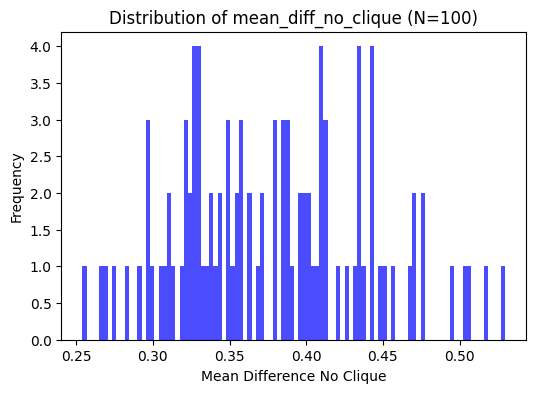

Precomputing variables...
Completed precomputing variables...
Testing N = 150
Mean diff no clique:
tensor([0.2802, 0.3723, 0.2760, 0.3472, 0.4893, 0.2663, 0.4597, 0.3079, 0.3601,
        0.3838, 0.3464, 0.3321, 0.4049, 0.3428, 0.3277, 0.2845, 0.4192, 0.3411,
        0.1779, 0.3841, 0.2704, 0.3526, 0.3695, 0.3046, 0.3524, 0.3102, 0.3459,
        0.2889, 0.3010, 0.3662, 0.3339, 0.3483, 0.3505, 0.4126, 0.3946, 0.4272,
        0.3795, 0.3775, 0.2644, 0.3959, 0.4481, 0.3825, 0.3524, 0.4157, 0.3265,
        0.3194, 0.2921, 0.3768, 0.3629, 0.4228, 0.3248, 0.3222, 0.2939, 0.3189,
        0.3167, 0.3990, 0.3459, 0.3282, 0.3334, 0.3554, 0.2914, 0.3868, 0.3562,
        0.3324, 0.3125, 0.3600, 0.3696, 0.3521, 0.3566, 0.3807, 0.4051, 0.3363,
        0.3097, 0.3379, 0.3337, 0.3636, 0.3746, 0.3238, 0.3671, 0.3595, 0.3194,
        0.3052, 0.2504, 0.3304, 0.4422, 0.4146, 0.3656, 0.3459, 0.3424, 0.3079,
        0.4173, 0.3475, 0.3529, 0.3983, 0.3802, 0.3423, 0.3272, 0.3154, 0.3477,
        0.3745])


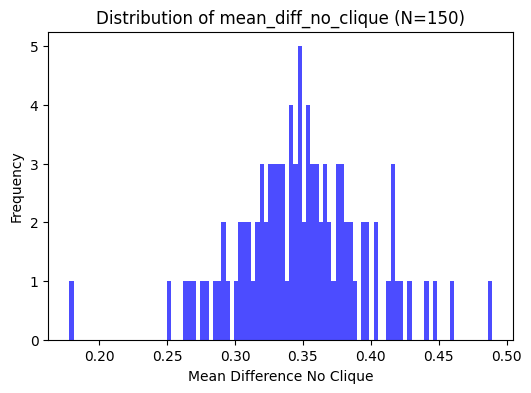

Precomputing variables...
Completed precomputing variables...
Testing N = 200
Mean diff no clique:
tensor([0.2297, 0.3427, 0.2736, 0.3669, 0.3560, 0.3576, 0.2507, 0.3000, 0.3122,
        0.3363, 0.2758, 0.2797, 0.3666, 0.2900, 0.2230, 0.3564, 0.3341, 0.3092,
        0.3202, 0.2457, 0.3929, 0.3087, 0.2791, 0.3417, 0.3574, 0.2624, 0.3374,
        0.2828, 0.3463, 0.3462, 0.2846, 0.3267, 0.3187, 0.3299, 0.3643, 0.3773,
        0.3442, 0.3897, 0.2865, 0.3647, 0.3845, 0.2682, 0.3425, 0.2649, 0.2496,
        0.3157, 0.2809, 0.3093, 0.2943, 0.3003, 0.3075, 0.2683, 0.3442, 0.3131,
        0.3091, 0.3474, 0.3850, 0.3557, 0.3310, 0.3714, 0.2806, 0.2918, 0.2891,
        0.3452, 0.3401, 0.2516, 0.3067, 0.3021, 0.2961, 0.3193, 0.3077, 0.3574,
        0.3298, 0.3035, 0.3901, 0.3312, 0.3550, 0.3452, 0.2979, 0.3909, 0.3132,
        0.2776, 0.4011, 0.2829, 0.3056, 0.4038, 0.3852, 0.2960, 0.2614, 0.4087,
        0.3691, 0.2924, 0.3605, 0.3118, 0.3923, 0.2982, 0.3006, 0.2874, 0.3570,
        0.3403])


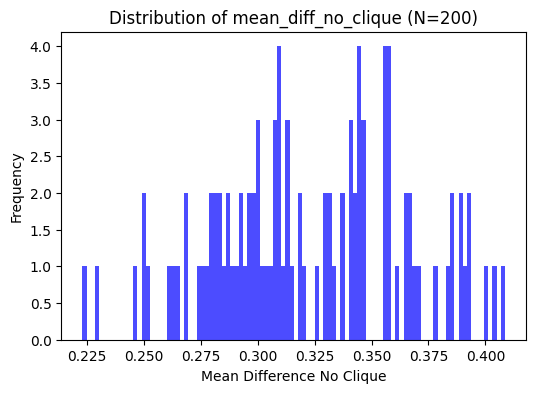

Precomputing variables...
Completed precomputing variables...
Testing N = 300
Mean diff no clique:
tensor([0.2458, 0.3089, 0.3095, 0.3061, 0.3162, 0.3359, 0.2593, 0.2819, 0.2710,
        0.3807, 0.2619, 0.3356, 0.3157, 0.3115, 0.3280, 0.2928, 0.3308, 0.3483,
        0.2737, 0.3209, 0.3485, 0.3238, 0.2643, 0.3602, 0.2380, 0.2836, 0.2401,
        0.3093, 0.2700, 0.3194, 0.3265, 0.2311, 0.2853, 0.3006, 0.2697, 0.3650,
        0.3411, 0.2950, 0.2899, 0.3591, 0.2877, 0.2948, 0.3669, 0.2893, 0.3378,
        0.2452, 0.2782, 0.2810, 0.3013, 0.3152, 0.2465, 0.3364, 0.3370, 0.3270,
        0.2895, 0.3178, 0.2773, 0.3533, 0.2529, 0.2665, 0.2756, 0.3413, 0.2551,
        0.2836, 0.3382, 0.2543, 0.3437, 0.2928, 0.3139, 0.3135, 0.3211, 0.2785,
        0.2446, 0.3126, 0.3166, 0.3286, 0.3273, 0.3023, 0.2406, 0.3177, 0.3373,
        0.3053, 0.2848, 0.3107, 0.2861, 0.3568, 0.3321, 0.2547, 0.3193, 0.2865,
        0.2899, 0.2781, 0.2815, 0.3202, 0.3071, 0.2853, 0.3214, 0.2656, 0.2884,
        0.3702])


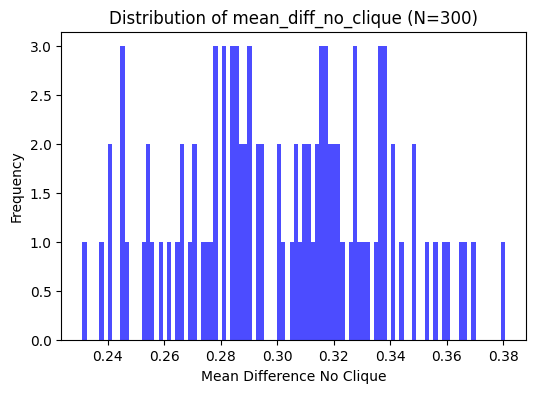

Precomputing variables...
Completed precomputing variables...
Testing N = 400
Mean diff no clique:
tensor([0.2462, 0.2769, 0.2821, 0.3053, 0.3115, 0.2407, 0.2710, 0.3079, 0.3327,
        0.2895, 0.2898, 0.2691, 0.3175, 0.3029, 0.1912, 0.2877, 0.2751, 0.2978,
        0.2662, 0.3041, 0.3040, 0.3213, 0.2528, 0.2706, 0.2449, 0.2379, 0.2726,
        0.3247, 0.2883, 0.2795, 0.2422, 0.2484, 0.2339, 0.2604, 0.3015, 0.2638,
        0.2778, 0.2580, 0.2806, 0.3019, 0.3134, 0.2915, 0.2579, 0.2854, 0.2800,
        0.2711, 0.2888, 0.2572, 0.2410, 0.2843, 0.3029, 0.2835, 0.2733, 0.2373,
        0.2786, 0.3525, 0.2856, 0.2686, 0.2770, 0.2444, 0.3053, 0.2601, 0.2579,
        0.2875, 0.2869, 0.2920, 0.3401, 0.2755, 0.2938, 0.2989, 0.2865, 0.2899,
        0.2401, 0.2606, 0.2708, 0.2975, 0.2384, 0.2827, 0.3169, 0.2828, 0.2989,
        0.2784, 0.2752, 0.2757, 0.2526, 0.2835, 0.2944, 0.2890, 0.3389, 0.2718,
        0.2934, 0.2541, 0.2277, 0.2059, 0.2656, 0.2329, 0.3050, 0.2672, 0.2539,
        0.2503])


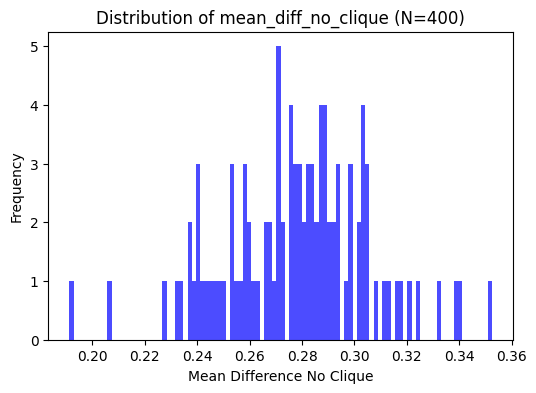

Precomputing variables...
Completed precomputing variables...
Testing N = 480
Mean diff no clique:
tensor([0.2703, 0.2985, 0.2512, 0.3115, 0.2703, 0.2744, 0.2240, 0.2701, 0.2164,
        0.2474, 0.2564, 0.2310, 0.2293, 0.2321, 0.2142, 0.2330, 0.2709, 0.2443,
        0.3453, 0.3228, 0.2826, 0.2517, 0.2751, 0.2531, 0.2137, 0.2440, 0.2720,
        0.2165, 0.2356, 0.2076, 0.3116, 0.2709, 0.2521, 0.2593, 0.2591, 0.2633,
        0.3027, 0.2191, 0.2821, 0.2767, 0.2351, 0.2480, 0.2690, 0.2435, 0.2443,
        0.2185, 0.2567, 0.2392, 0.2739, 0.2246, 0.2501, 0.2274, 0.2574, 0.2607,
        0.2264, 0.2603, 0.2649, 0.2560, 0.3090, 0.2926, 0.1956, 0.2634, 0.2540,
        0.2596, 0.2542, 0.2702, 0.2682, 0.2532, 0.3304, 0.3067, 0.2501, 0.2611,
        0.2360, 0.2432, 0.2624, 0.2283, 0.2892, 0.2591, 0.2526, 0.3155, 0.2556,
        0.2509, 0.2611, 0.2631, 0.2329, 0.2521, 0.2497, 0.2442, 0.2628, 0.2831,
        0.3316, 0.2715, 0.2808, 0.3012, 0.2576, 0.2798, 0.2321, 0.2243, 0.3001,
        0.2404])


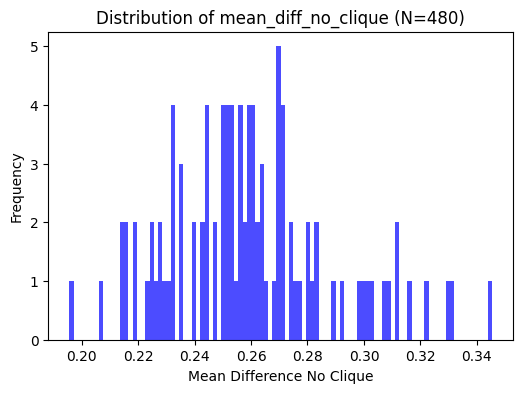

Precomputing variables...
Completed precomputing variables...
Testing N = 600
Mean diff no clique:
tensor([0.2630, 0.2187, 0.2895, 0.2538, 0.2353, 0.2429, 0.2414, 0.2221, 0.2442,
        0.2551, 0.2469, 0.2838, 0.2214, 0.2601, 0.2439, 0.2251, 0.2966, 0.2630,
        0.2458, 0.2014, 0.2525, 0.2363, 0.2407, 0.2093, 0.2195, 0.2158, 0.2523,
        0.2622, 0.2563, 0.2549, 0.2835, 0.2571, 0.2195, 0.2539, 0.2464, 0.2876,
        0.2496, 0.2483, 0.2161, 0.2545, 0.2110, 0.2918, 0.2418, 0.2254, 0.2502,
        0.3081, 0.2286, 0.2920, 0.2588, 0.2147, 0.2758, 0.2997, 0.2199, 0.2592,
        0.2139, 0.2354, 0.2454, 0.2172, 0.2147, 0.2916, 0.2295, 0.2121, 0.2598,
        0.2611, 0.2043, 0.2695, 0.2471, 0.2599, 0.2519, 0.2402, 0.2467, 0.2451,
        0.2652, 0.2546, 0.2128, 0.2689, 0.2603, 0.2377, 0.2772, 0.2944, 0.1948,
        0.2426, 0.2468, 0.2549, 0.3129, 0.3120, 0.3080, 0.1803, 0.2827, 0.2656,
        0.2482, 0.2528, 0.2487, 0.2361, 0.2401, 0.2190, 0.2262, 0.2717, 0.2494,
        0.2857])


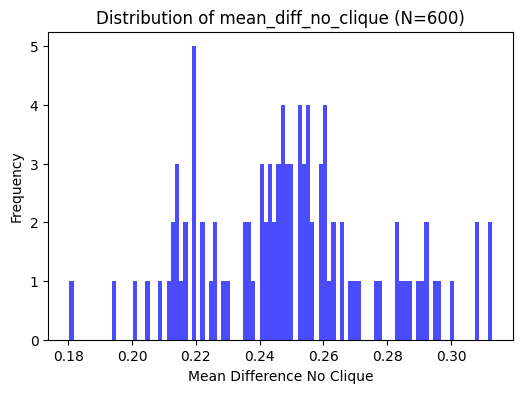

Precomputing variables...
Completed precomputing variables...
Testing N = 800
Mean diff no clique:
tensor([0.2243, 0.2333, 0.2445, 0.2361, 0.2232, 0.2234, 0.2420, 0.2298, 0.2425,
        0.1943, 0.2193, 0.2355, 0.2299, 0.2110, 0.2875, 0.2147, 0.2154, 0.2669,
        0.2210, 0.2175, 0.2382, 0.2245, 0.1992, 0.2509, 0.2267, 0.1820, 0.2095,
        0.2843, 0.2491, 0.2427, 0.2796, 0.2272, 0.2544, 0.2349, 0.2561, 0.2266,
        0.2451, 0.2473, 0.2394, 0.2525, 0.2455, 0.2179, 0.2365, 0.2361, 0.2321,
        0.2304, 0.2347, 0.2355, 0.2604, 0.2504, 0.2418, 0.2526, 0.2307, 0.2114,
        0.2198, 0.2112, 0.2240, 0.2528, 0.1931, 0.2164, 0.2430, 0.2235, 0.2506,
        0.2178, 0.2225, 0.2546, 0.2203, 0.2382, 0.2416, 0.2606, 0.2308, 0.2110,
        0.2265, 0.2170, 0.2383, 0.3093, 0.2721, 0.2651, 0.2484, 0.2240, 0.2741,
        0.2417, 0.1937, 0.2334, 0.2041, 0.2401, 0.2372, 0.2491, 0.2209, 0.2355,
        0.2633, 0.2068, 0.2486, 0.2615, 0.2164, 0.2110, 0.2092, 0.2213, 0.2080,
        0.2295])


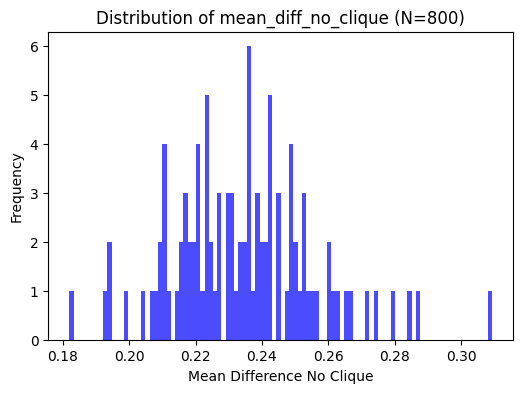

Precomputing variables...
Completed precomputing variables...
Testing N = 1200
Mean diff no clique:
tensor([0.2338, 0.2294, 0.2109, 0.1782, 0.1824, 0.1970, 0.1988, 0.2090, 0.2040,
        0.1688, 0.2230, 0.2194, 0.2137, 0.2003, 0.1930, 0.2201, 0.2517, 0.2314,
        0.2172, 0.1619, 0.2258, 0.1940, 0.2081, 0.1975, 0.2237, 0.2199, 0.2279,
        0.2173, 0.2199, 0.1982, 0.1839, 0.2368, 0.2145, 0.2037, 0.2284, 0.2183,
        0.2170, 0.2299, 0.2081, 0.2018, 0.2162, 0.1919, 0.2209, 0.1925, 0.1868,
        0.2208, 0.2087, 0.2041, 0.2424, 0.2162, 0.2126, 0.1945, 0.2511, 0.1902,
        0.2396, 0.2072, 0.1868, 0.2187, 0.2355, 0.2216, 0.2346, 0.2304, 0.2096,
        0.2083, 0.2222, 0.2189, 0.2576, 0.2008, 0.1917, 0.2215, 0.2082, 0.2292,
        0.2267, 0.2339, 0.2097, 0.2115, 0.2140, 0.2164, 0.1876, 0.1928, 0.2083,
        0.2009, 0.2219, 0.1956, 0.1967, 0.2676, 0.1968, 0.2105, 0.1969, 0.1837,
        0.2111, 0.1729, 0.1713, 0.2189, 0.2252, 0.1990, 0.2190, 0.2175, 0.2337,
        0.2056])


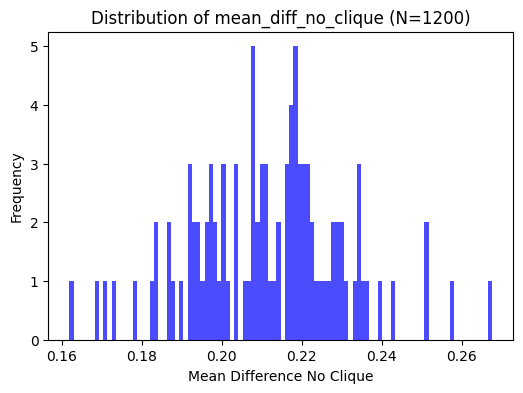

In [9]:
# read configuration file:
config = load_config(
    os.path.join("Ideal-MLP_test_config.yml")
)  # CHANGE THIS TO PERFORM DIFFERENT EXPERIMENTS

N_graphs = 100 
    
# looping over the different graph sizes in the experiment:
for graph_size in config["graph_size_values"]:
    ideal_MLP = Ideal_MLP_k_unknown(graph_size)
    print("Testing N =", graph_size)
    clique_size_fraction = 0.2
    graphs_without_clique = graphs_gen.generate_batch(N_graphs, graph_size, np.repeat([int(clique_size_fraction*graph_size)],N_graphs), "p_reduce", False, p_clique=0.000000000001)
    labels = graphs_without_clique[1]
    ideal_MLP(graphs_without_clique[0])

### Logistic regression to calculate threshold for each N value

In [6]:
# customize function to generate batch of clique size values (all clique size values from STAT-LIMIT to max_clique_size_proportion_test*N are equally probable)
def generate_batch_clique_sizes(allowed_clique_sizes, batch_size):
    """
    Generate the clique sizes for each graph in the batch (based on the allowed clique size values).

    Parameters:
    allowed_clique_sizes (np.ndarray): Allowed clique size values.
    batch_size (int): Size of the batch to generate.

    Returns:
    np.ndarray: Array of generated clique sizes for each graph in the batch.
    """
    # TESTING INPUT VALUES:
    if not isinstance(allowed_clique_sizes, np.ndarray):
        raise ValueError("allowed_clique_sizes must be a numpy array")
    if not isinstance(batch_size, int):
        raise ValueError("batch_size must be an integer")
    # END TESTING INPUT VALUES

    # - define single prob value
    prob_each = 1 / len(allowed_clique_sizes)
    allowed_clique_sizes_probs = np.full(len(allowed_clique_sizes), prob_each)

    # Normalize the probabilities to ensure they sum to 1 (in case of rounding errors)
    allowed_clique_sizes_probs /= np.sum(allowed_clique_sizes_probs)
    
    # Generate the clique size array
    batch_clique_sizes = np.random.choice(
        allowed_clique_sizes, batch_size, p=allowed_clique_sizes_probs
    )
    
    return batch_clique_sizes

# testing function:
batch_clique_sizes = generate_batch_clique_sizes(np.array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
        31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70]), 32)
print(batch_clique_sizes)

[45 19 56 34 42 53 46 20 13 13 57 65 28 22 40 20 59 30 20 25 67 17 34 37
 65 45 40 63 57 33 37 49]


Configuration file loaded successfully.
Precomputing variables...
Clique size values:  tensor([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
        31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70])
Completed precomputing variables...


C:\Users\danie\AppData\Local\Temp\ipykernel_23928\2499956383.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_K = torch.tensor(expected_count_clique(tau, graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts


(3200,)
Estimated threshold: 0.4967528298227377
Total number of graphs analyzed:  3200


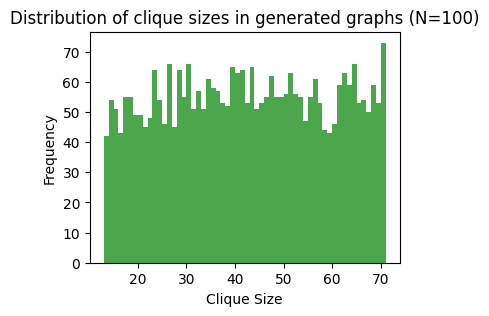

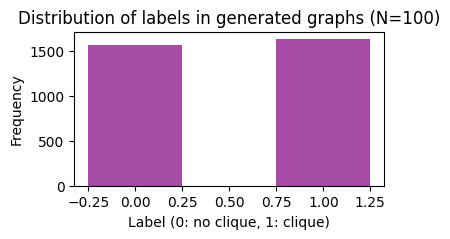

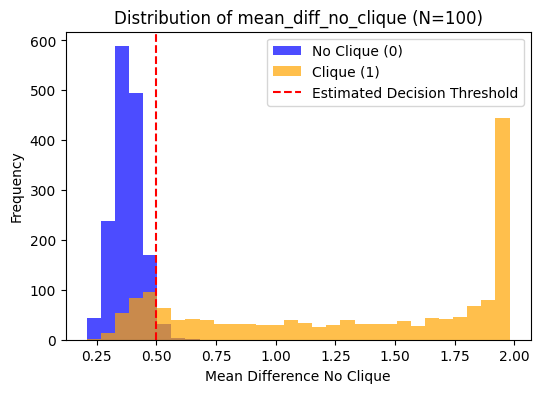

Precomputing variables...
Clique size values:  tensor([ 14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105])
Completed precomputing variables...


C:\Users\danie\AppData\Local\Temp\ipykernel_23928\2499956383.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_K = torch.tensor(expected_count_clique(tau, graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts


(3200,)
Estimated threshold: 0.45533275291193204
Total number of graphs analyzed:  3200


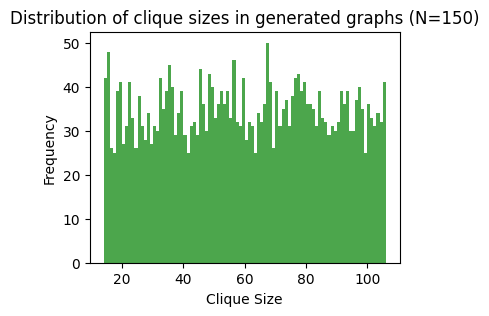

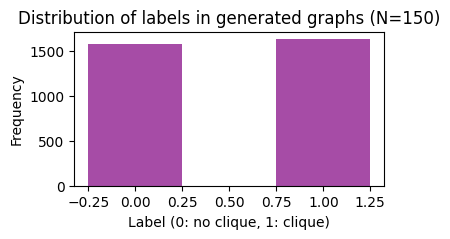

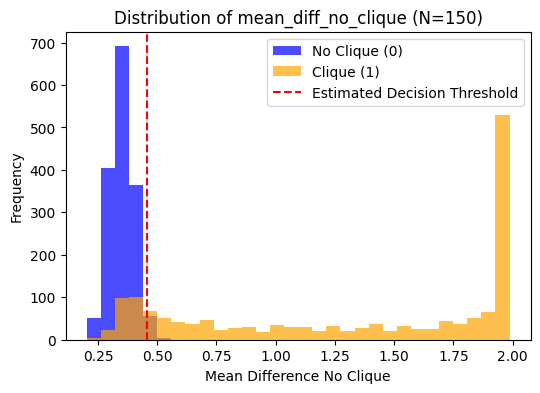

Precomputing variables...
Clique size values:  tensor([ 15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140])
Completed precomputing variables...


C:\Users\danie\AppData\Local\Temp\ipykernel_23928\2499956383.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_K = torch.tensor(expected_count_clique(tau, graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts


(3200,)
Estimated threshold: 0.4280529651659371
Total number of graphs analyzed:  3200


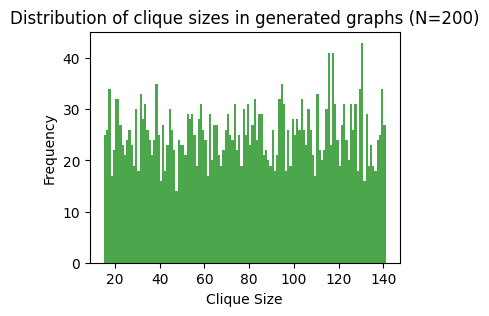

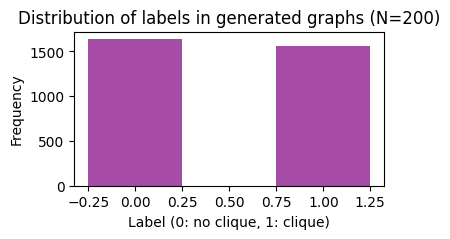

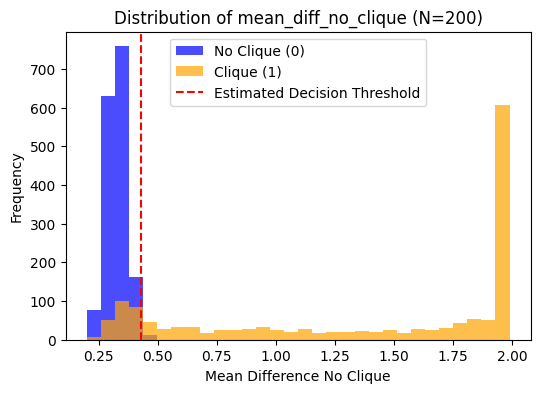

Precomputing variables...
Clique size values:  tensor([ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
         44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
         58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
         72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
         86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185,

C:\Users\danie\AppData\Local\Temp\ipykernel_23928\2499956383.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_K = torch.tensor(expected_count_clique(tau, graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts


Completed precomputing variables...
(3200,)
Estimated threshold: 0.3809736060989176
Total number of graphs analyzed:  3200


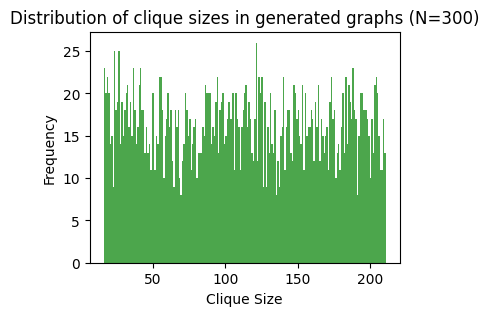

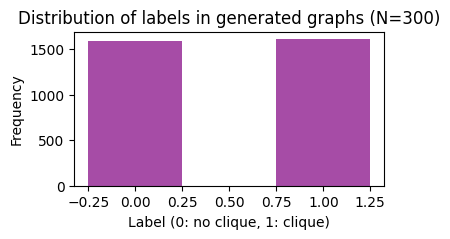

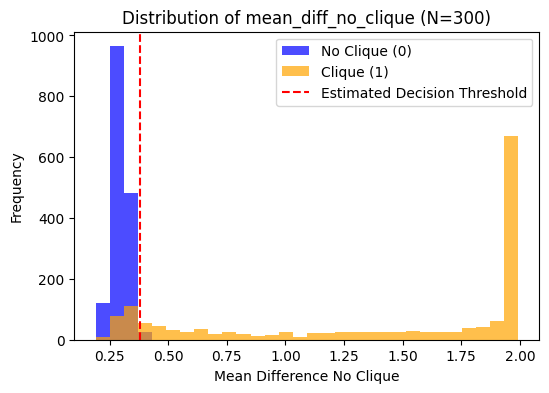

Precomputing variables...
Clique size values:  tensor([ 17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
         31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
         45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
         59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
         73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
        171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
        185, 186,

C:\Users\danie\AppData\Local\Temp\ipykernel_23928\2499956383.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_K = torch.tensor(expected_count_clique(tau, graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts


Completed precomputing variables...
(3200,)
Estimated threshold: 0.3597325164312861
Total number of graphs analyzed:  3200


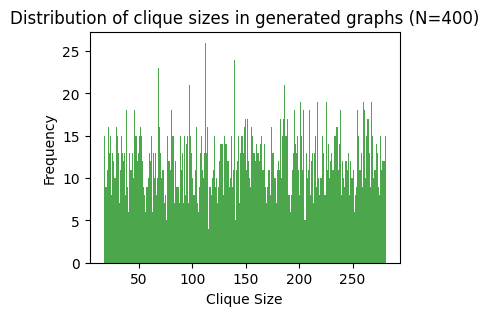

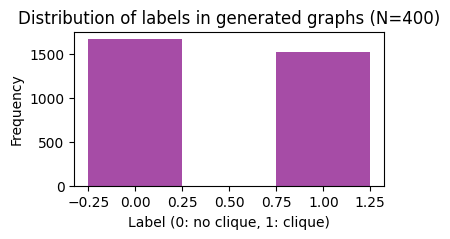

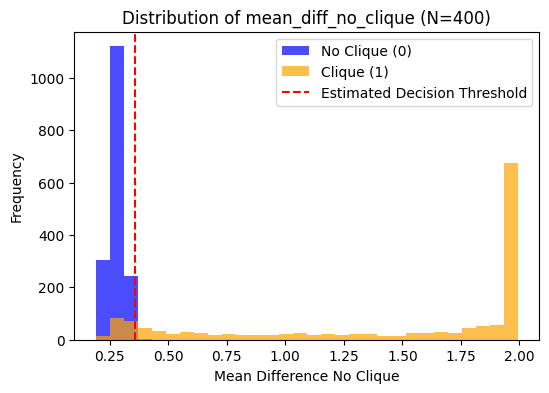

Precomputing variables...
Clique size values:  tensor([ 18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
         32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
         46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
         60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
         74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
         88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
        158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
        172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
        186, 187,

C:\Users\danie\AppData\Local\Temp\ipykernel_23928\2499956383.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_K = torch.tensor(expected_count_clique(tau, graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts


Completed precomputing variables...
(3200,)
Estimated threshold: 0.3403996570676968
Total number of graphs analyzed:  3200


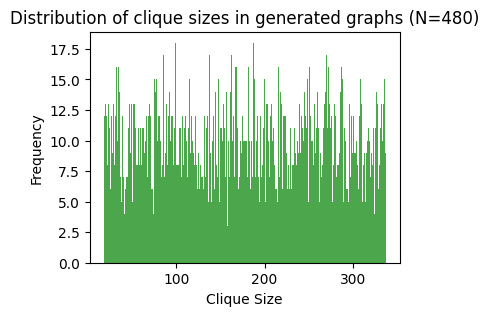

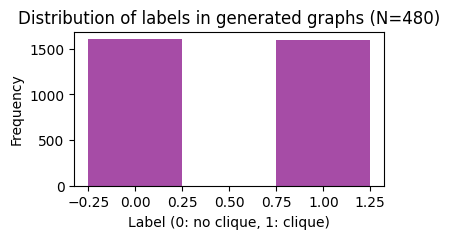

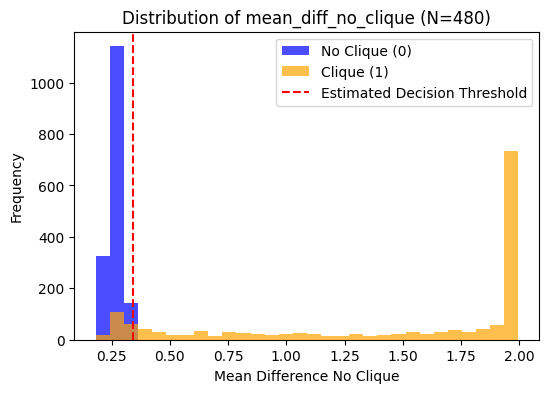

Precomputing variables...
Clique size values:  tensor([ 18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
         32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
         46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
         60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
         74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
         88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
        158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
        172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
        186, 187,

C:\Users\danie\AppData\Local\Temp\ipykernel_23928\2499956383.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_K = torch.tensor(expected_count_clique(tau, graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts


Completed precomputing variables...
(3200,)
Estimated threshold: 0.3212365356101493
Total number of graphs analyzed:  3200


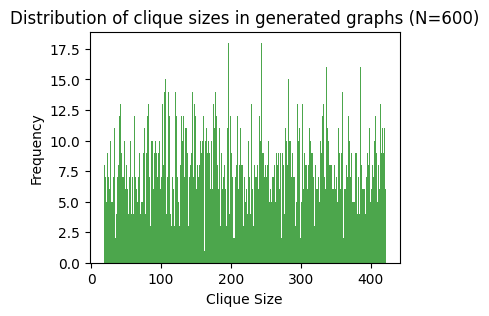

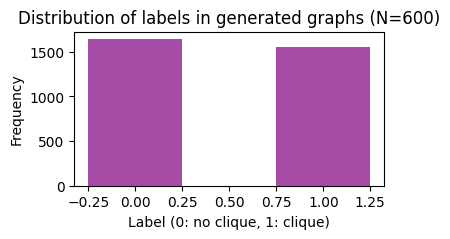

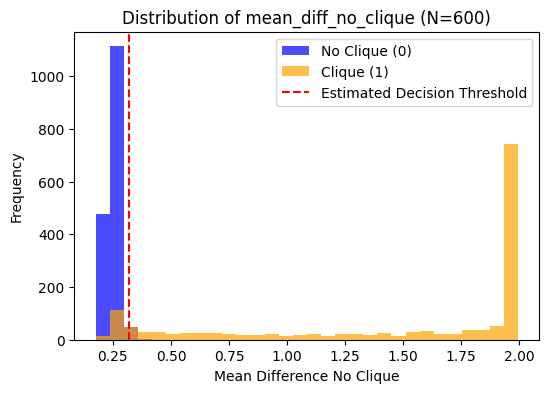

Precomputing variables...
Clique size values:  tensor([ 19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
         33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
         47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
         61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
         75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
        159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
        173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
        187, 188,

C:\Users\danie\AppData\Local\Temp\ipykernel_23928\2499956383.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_K = torch.tensor(expected_count_clique(tau, graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts


Completed precomputing variables...
(3200,)
Estimated threshold: 0.2937466256098939
Total number of graphs analyzed:  3200


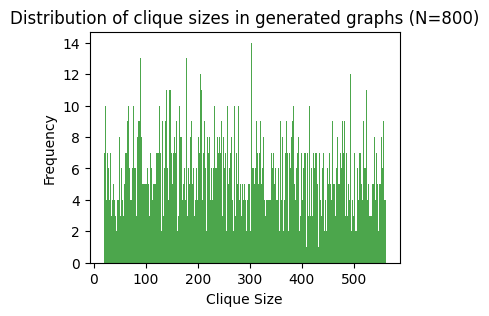

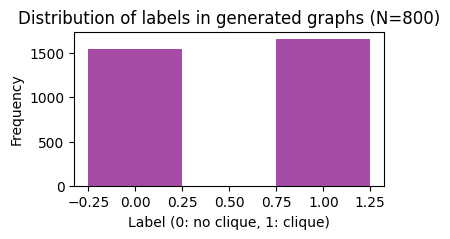

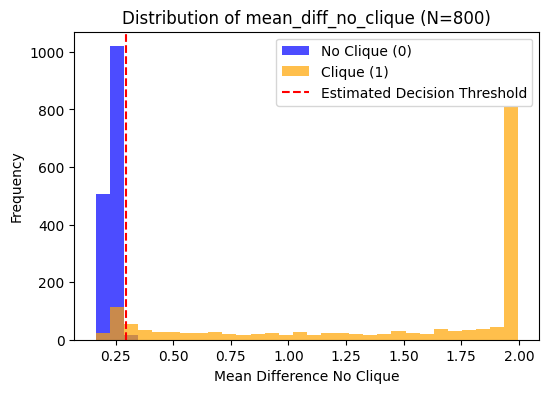

Precomputing variables...
Clique size values:  tensor([ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
         34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
         48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
         62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
        146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
        174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
        188, 189,

C:\Users\danie\AppData\Local\Temp\ipykernel_23928\2499956383.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_K = torch.tensor(expected_count_clique(tau, graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts


Completed precomputing variables...
(3200,)
Estimated threshold: 0.2683396524838787
Total number of graphs analyzed:  3200


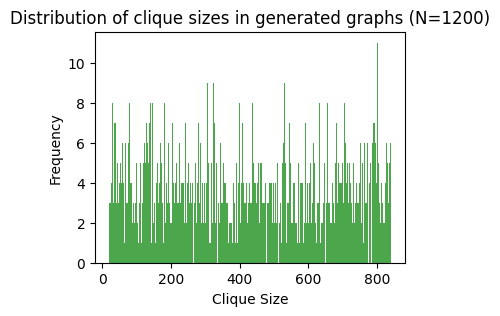

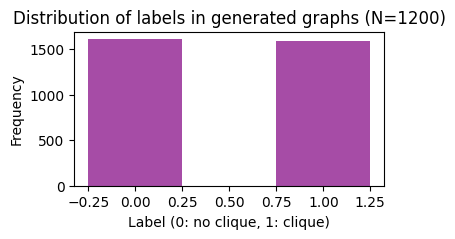

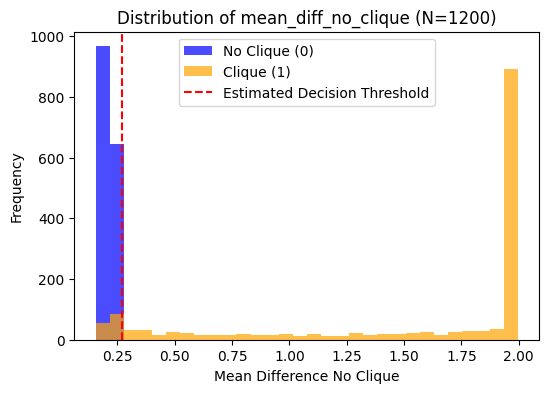

In [10]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# read configuration file:
config = load_config(
    os.path.join("Ideal-MLP_test_config.yml")
)  # CHANGE THIS TO PERFORM DIFFERENT EXPERIMENTS

# number of batches to generate:
num_batches = 100
    
# looping over the different graph sizes in the experiment:
for graph_size in config["graph_size_values"]:
    # Precomputing variables:
    print("Precomputing variables...")
    # - array of bin edges: 
    tau = torch.arange(0, graph_size+1) #NOTE: possible improvement is extending this to actual bins spanning more than 1 single value
    #print("Tau values: ", tau)
    # - array of clique size values:
    max_K = int(0.7 * graph_size)
    stat_lim = round(2 * math.log2(graph_size))
    # if K-not-known, consider clique size values only down to stat limit (to reduce "no clique" bias)
    clique_size_values = torch.arange(stat_lim, max_K + 1)
        
    print("Clique size values: ", clique_size_values)
    # - compute expected histograms and store as torch.float32 tensors
    # -- no clique
    expected_hist_no_clique = torch.tensor(
        expected_count_noclique(tau, graph_size), dtype=torch.float32
    )  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts
    expected_hist_clique = []
    expected_hist_clique_std = []
    # -- clique (calculating expected histogram for all possible clique size values)
    for K in clique_size_values:
        p_corrected = p_correction(0.5, graph_size, K)
        expected_hist_K = torch.tensor(expected_count_clique(tau, graph_size, K, p_corrected), dtype=torch.float32)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts
        expected_hist_clique.append(expected_hist_K)
        expected_hist_K_std = torch.sqrt(graph_size * (expected_hist_K / graph_size) * (1 - expected_hist_K / graph_size) ).clamp(min=1e-6)
        expected_hist_clique_std.append(expected_hist_K_std)
    expected_hist_clique = torch.stack(expected_hist_clique, dim=1)  # shape: (len_tau, len_clique_size_values) 
    print("Completed precomputing variables...")
    
    mean_diff_no_clique = []
    labels = []
    clique_sizes = []
    for batch in np.arange(num_batches):
        batch_clique_sizes = generate_batch_clique_sizes(np.array(clique_size_values), config["testing_parameters"]["num_test"])
        clique_sizes.append(batch_clique_sizes)
        
        # generate batch of graphs:
        graphs_batch, labels_batch = graphs_gen.generate_batch(config["testing_parameters"]["num_test"], graph_size, batch_clique_sizes, "p_reduce", False)
    
        # compute degree of each node (sum over rows)
        degrees = torch.sum(graphs_batch, dim=2)  # shape: (batch_size, 1, N)
        degrees = degrees.squeeze(1)  # shape: (batch_size, N)
        # Vectorized: degrees shape (batch_size, N)
        batch_size, N = degrees.shape
        len_tau = len(tau)
        # cast tau to same dtype/device and reshape for broadcasting:
        tau_val = tau.to(dtype=degrees.dtype, device=degrees.device).view(1, len_tau, 1)  # shape: (1, len_tau, 1)
        deg_batched = degrees.view(batch_size, 1, N)  # shape: (batch_size, 1, N)

        # "left" block (broadcasts to (batch_size, len_tau, N))
        x_left = torch.relu(deg_batched - (tau_val - 2.0))
        x_left = torch.relu(2.0 - x_left)
        left = x_left - torch.relu(x_left - 1.0)

        # "right" block (broadcasts to (batch_size, len_tau, N))
        x_right = torch.relu(deg_batched - (tau_val - 1.0))
        x_right = torch.relu(2.0 - x_right)
        right = x_right - torch.relu(x_right - 1.0)

        # indicator matrix per graph: (batch_size, len_tau, N)
        degree_indicator_matrices = (right - left)  # float tensor with 0/1 values

        # summing over nodes to get raw histograms:
        raw_histograms = degree_indicator_matrices.sum(dim=2)  # shape (batch_size, len_tau)
        
        # computing differences with expected histograms:
        # - no clique case:
        expected_no_clique = expected_hist_no_clique.to(dtype=degrees.dtype, device=degrees.device).view(1, len_tau)  # shape: (1, len_tau)
        # - no standardization:
        diff_no_clique = torch.abs(raw_histograms - expected_no_clique)  # shape: (batch_size, len_tau)            
        mean_diff_no_clique_batch = diff_no_clique.mean(dim=1)  # shape: (batch_size,)  
        
        mean_diff_no_clique.append(mean_diff_no_clique_batch)
        labels.append(labels_batch)
        
        # freeing memory:
        del graphs_batch, degrees, deg_batched, x_left, x_right, left, right, degree_indicator_matrices, raw_histograms, expected_no_clique, diff_no_clique

    # converting lists to tensors:
    clique_sizes = torch.cat([torch.tensor(c) for c in clique_sizes], dim=0)
    mean_diff_no_clique = torch.cat(mean_diff_no_clique, dim=0)
    labels = torch.cat([torch.tensor(l) for l in labels], dim=0)       
    
    # defining binary threshold to distinguish "clique" and "no-clique" graphs
    # - Using binary logistic regression (and not LDA) since "clique" distribution is not normal (it is bimodal) [https://en.wikipedia.org/wiki/Logistic_regression]
    # - Parameters estimated by MLE
    
    # Convert to numpy arrays
    X = np.asarray(mean_diff_no_clique).reshape(-1, 1)
    y = np.asarray(labels)
    print(y.shape)
    # Fit logistic regression using MLE
    model = LogisticRegression(
        penalty=None,   # no regularization → pure MLE
        solver="lbfgs"
    )
    model.fit(X, y)
    # Extract coefficients
    beta_0 = model.intercept_[0]
    beta_1 = model.coef_[0, 0]
    # Compute threshold
    threshold = -beta_0 / beta_1
    print("Estimated threshold:", threshold)
    
    # sanity check:
    print("Total number of graphs analyzed: ", mean_diff_no_clique.shape[0])    
    
    # 1. Visualize the distribution of clique sizes in generated graphs (sanity check, should be uniform):
    plt.figure(figsize=(4,3))
    plt.hist(clique_sizes.detach().cpu().numpy(), bins=range(int(clique_size_values[0]), int(clique_size_values[-1])+2), color='green', alpha=0.7)
    plt.title(f"Distribution of clique sizes in generated graphs (N={graph_size})")
    plt.xlabel("Clique Size")
    plt.ylabel("Frequency")
    plt.show()
    
    # 2. Visualize the distribution of labels in generated graphs (sanity check, should be approx. 50-50):
    plt.figure(figsize=(4,2))
    plt.hist(labels.detach().cpu().numpy(), bins=[-0.25, 0.25, 0.75, 1.25], color='purple', alpha=0.7)
    plt.title(f"Distribution of labels in generated graphs (N={graph_size})")
    plt.xlabel("Label (0: no clique, 1: clique)")
    plt.ylabel("Frequency")
    plt.show()
    
    # 3. Visualize the "mean_diff_no_clique" distribution (no clique "0" in blue, clique "1" in orange), together with the estimated decision threshold:
    mean_diff_np = mean_diff_no_clique.detach().cpu().numpy()
    labels_np = labels.detach().cpu().numpy()
    # compute shared bin edges from combined data (30 bins)
    common_bins = np.histogram_bin_edges(mean_diff_np, bins=30)    
    plt.figure(figsize=(6,4))
    plt.hist(mean_diff_np[labels_np==0], bins=common_bins, color='blue', alpha=0.7, label='No Clique (0)')
    plt.hist(mean_diff_np[labels_np==1], bins=common_bins, color='orange', alpha=0.7, label='Clique (1)')
    plt.axvline(x=threshold, color='red', linestyle='--', label='Estimated Decision Threshold')
    plt.title(f"Distribution of mean_diff_no_clique (N={graph_size})")
    plt.xlabel("Mean Difference No Clique")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


In [ ]:
class Ideal_MLP_k_unknown(nn.Module):
        
    def __init__(self, graph_size:int, max_clique_prop:float = 0.7, k_known:bool = False):
        super().__init__()
        self.graph_size = torch.tensor(graph_size, dtype=torch.int32)
        self.k_known = k_known
        

    # Processing blocks:
    def forward(self, adj_matrices: torch.Tensor):
        '''
        Input: adj_matrices of shape [batch_size, 1, N, N]
        Output: tensor of shape [batch_size] (probability of "clique")
        '''
        if(adj_matrices.shape[2] != self.graph_size):
            raise ValueError(f"Input graphs have size {adj_matrices.shape[2]}, but model was initialized for size {self.graph_size}")

        # compute degree of each node (sum over rows)
        degrees = torch.sum(adj_matrices, dim=2)  # shape: (batch_size, 1, N)
        degrees = degrees.squeeze(1)  # shape: (batch_size, N)
        
        # Vectorized: degrees shape (batch_size, N)
        batch_size, N = degrees.shape
        len_tau = len(self.tau)

        # cast tau to same dtype/device and reshape for broadcasting:
        tau_val = self.tau.to(dtype=degrees.dtype, device=degrees.device).view(1, len_tau, 1)  # shape: (1, len_tau, 1)
        deg_batched = degrees.view(batch_size, 1, N)  # shape: (batch_size, 1, N)

        # "left" block (broadcasts to (batch_size, len_tau, N))
        x_left = torch.relu(deg_batched - (tau_val - 2.0))
        x_left = torch.relu(2.0 - x_left)
        left = x_left - torch.relu(x_left - 1.0)

        # "right" block (broadcasts to (batch_size, len_tau, N))
        x_right = torch.relu(deg_batched - (tau_val - 1.0))
        x_right = torch.relu(2.0 - x_right)
        right = x_right - torch.relu(x_right - 1.0)

        # indicator matrix per graph: (batch_size, len_tau, N)
        degree_indicator_matrices = (right - left)  # float tensor with 0/1 values

        # summing over nodes to get raw histograms:
        raw_histograms = degree_indicator_matrices.sum(dim=2)  # shape (batch_size, len_tau)
        
        # computing differences with expected histograms:
        # - no clique case:
        expected_no_clique = self.expected_hist_no_clique.to(dtype=degrees.dtype, device=degrees.device).view(1, len_tau)  # shape: (1, len_tau)
        # - no standardization:
        diff_no_clique = torch.abs(raw_histograms - expected_no_clique)  # shape: (batch_size, len_tau)            
        mean_diff_no_clique = diff_no_clique.mean(dim=1)  # shape: (batch_size,)  
        
        print("Mean diff no clique:")
        print(mean_diff_no_clique)

        # Visualize the "mean_diff_no_clique" distribution:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(6,4))
        plt.hist(mean_diff_no_clique.detach().cpu().numpy(), bins=100, color='blue', alpha=0.7)
        plt.title("Distribution of mean_diff_no_clique")
        plt.xlabel("Mean Difference No Clique")
        plt.ylabel("Frequency")
        plt.show()
        

### Testing Ideal MLP (K-not-known) with estimated thresholds

## Number of parameters calculation

----------------

In [ ]:
class Ideal_MLP(nn.Module):
    
    # NOTE possible improvements:
    # - handle with actual bins (now n_bins = N)
    # - standardization before comparing clique/no clique
    # - "left" and "right" blocks can be simplified?
    
    def __init__(self, graph_size:int, max_clique_prop:float = 0.7):
        super().__init__()
        self.N = graph_size
        
        # Precomputing variables:
        print("Precomputing variables...")
        # - array of bin edges: 
        self.tau = torch.arange(0, self.N+1) #NOTE: possible improvement is extending this to actual bins spanning more than 1 single value
        #print("Tau values: ", self.tau)
        # - array of clique size values:
        max_K = int(max_clique_prop * self.N)
        stat_lim = round(2 * np.log2(self.N))
        self.clique_size_values = torch.arange(stat_lim, max_K + 1)  # from statistical limit to max_K
        print("Clique size values: ", self.clique_size_values)
        # - compute expected histograms and store as torch.float32 tensors
        self.expected_hist_no_clique = torch.tensor(
            expected_count_noclique(self.tau, self.N), dtype=torch.float32
        )  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts
        expected_hist_clique = []
        for K in self.clique_size_values:
            p_corrected = p_correction(0.5, self.N, K)
            expected_hist_K = expected_count_clique(self.tau, self.N, K, p_corrected)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts
            expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))
        self.expected_hist_clique = torch.stack(expected_hist_clique, dim=1)  # shape: (len_tau, len_clique_size_values)        
        print("Completed precomputing variables...")
        
    # Processing blocks:
    def forward(self, adj_matrices: torch.Tensor):
        '''
        Input: adj_matrices of shape [batch_size, 1, N, N]
        Output: tensor of shape [batch_size] (softmaxed score for no-clique (0) and clique (1) cases)
        '''
        if(adj_matrices.shape[2] != self.N):
            raise ValueError(f"Input graphs have size {adj_matrices.shape[2]}, but model was initialized for size {self.N}")
                    
        # compute degree of each node (sum over rows)
        degrees = torch.sum(adj_matrices, dim=2)  # shape: (batch_size, 1, N)
        degrees = degrees.squeeze(1)  # shape: (batch_size, N)
        
        # Vectorized: degrees shape (batch_size, N)
        batch_size, N = degrees.shape
        len_tau = len(self.tau)

        # cast tau to same dtype/device and reshape for broadcasting:
        tau_val = self.tau.to(dtype=degrees.dtype, device=degrees.device).view(1, len_tau, 1)  # shape: (1, len_tau, 1)
        deg_batched = degrees.view(batch_size, 1, N)  # shape: (batch_size, 1, N)

        # "left" block (broadcasts to (batch_size, len_tau, N))
        x_left = torch.relu(deg_batched - (tau_val - 2.0))
        x_left = torch.relu(2.0 - x_left)
        left = x_left - torch.relu(x_left - 1.0)

        # "right" block (broadcasts to (batch_size, len_tau, N))
        x_right = torch.relu(2.0 - torch.relu(deg_batched - (tau_val - 1.0)))
        right = x_right - torch.relu(x_right - 1.0)

        # indicator matrix per graph: (batch_size, len_tau, N)
        degree_indicator_matrices = (right - left)  # float tensor with 0/1 values
        #degree_indicator_matrices = (degree_indicator_matrices > 0.5).long()    # convert to int 0/1 values

        # summing over nodes to get raw histograms:
        raw_histograms = degree_indicator_matrices.sum(dim=2)  # shape (batch_size, len_tau)
        #print("raw histograms shape:", raw_histograms.shape)                
        
        # computing differences with expected histograms:
        # - no clique case:
        expected_no_clique = self.expected_hist_no_clique.to(dtype=degrees.dtype, device=degrees.device).view(1, len_tau)  # shape: (1, len_tau)
        diff_no_clique = torch.abs(raw_histograms - expected_no_clique)  # shape: (batch_size, len_tau)
        mean_diff_no_clique = torch.mean(diff_no_clique, dim=1)  # shape: (batch_size,)  
        # - clique case (per-clique-size differences, then average across clique sizes):
        #   - expected hist:
        expected_clique = self.expected_hist_clique.to(dtype=degrees.dtype, device=degrees.device)  # move to same dtype and device
        expected_clique = expected_clique.unsqueeze(0)  # add batch dimension: (1, len_tau, num_K)

        #   - raw_hist:
        raw_expanded = raw_histograms.unsqueeze(2)  # add clique-size dim for broadcasting: (batch_size, len_tau, 1)
        diff_clique_per_tau = torch.abs(raw_expanded - expected_clique)  # elementwise absolute difference per graph, per tau, per clique-size: (batch_size, len_tau, num_K)
        diff_clique_per_K = torch.mean(diff_clique_per_tau, dim=1)  # aggregate across tau to get one difference value per graph per clique-size (batch_size, num_K)
        mean_diff_clique = torch.mean(diff_clique_per_K, dim=1)  # (batch_size,)
        
        print("mean diff clique: ", mean_diff_clique)
        print("mean diff no clique: ", mean_diff_no_clique)
        
        # computing final decision for each graph (a smaller difference means a higher likelikood of that class)
        logits = mean_diff_no_clique - mean_diff_clique  # shape: (batch_size,): positive -> more likely clique, negative -> more likely no-clique
        print("logits: ", logits)
        probs = torch.sigmoid(logits)  # shape: (batch_size,) -> probability of responding "clique"
        #print("output probs shape:", probs.shape)
        #print("output probs:", probs)
        
        # Visualization of empirical histograms and expected counts       
        import matplotlib.pyplot as plt
        plt.plot(raw_histograms[0])   
        plt.plot(list(expected_no_clique.squeeze()))
        mean = np.array(list(expected_no_clique.squeeze()))
        std = np.sqrt(self.N * (mean/N)*(1-mean/N))
        plt.fill_between(np.arange(mean.size), mean-std, mean+std)               
        plt.plot(list(expected_clique[:,:,162].squeeze()))
        plt.xlim(200, 420)          
        
        return probs


Clique size of:  162  in a graph of size:  600


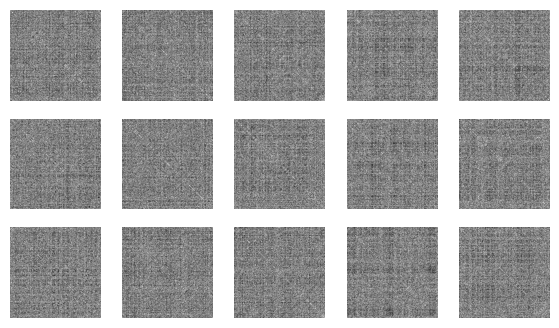

Precomputing variables...


C:\Users\danie\AppData\Local\Temp\ipykernel_21664\2315459437.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))


Completed precomputing variables...
mean diff clique:  tensor([1.4189, 1.4331, 1.4202, 1.4083, 1.4317, 1.4274, 1.4167, 1.4207, 1.4251,
        1.4293, 1.4267, 1.4120, 1.4138, 1.4083, 1.4358])
mean diff no clique:  tensor([1.4182, 1.4474, 1.4383, 1.4320, 1.4680, 1.4441, 1.4293, 1.4228, 1.4335,
        1.4603, 1.4652, 1.4117, 1.3917, 1.3799, 1.4819])
logits:  tensor([-0.0007,  0.0144,  0.0180,  0.0237,  0.0363,  0.0167,  0.0127,  0.0021,
         0.0085,  0.0310,  0.0386, -0.0004, -0.0221, -0.0284,  0.0461])
Soft outputs: tensor([0.4998, 0.5036, 0.5045, 0.5059, 0.5091, 0.5042, 0.5032, 0.5005, 0.5021,
        0.5078, 0.5096, 0.4999, 0.4945, 0.4929, 0.5115])
Hard outputs:  [0 1 1 1 1 1 1 1 1 1 1 0 0 0 1]
Labels:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Fraction of correct responses:
0.7333333333333333


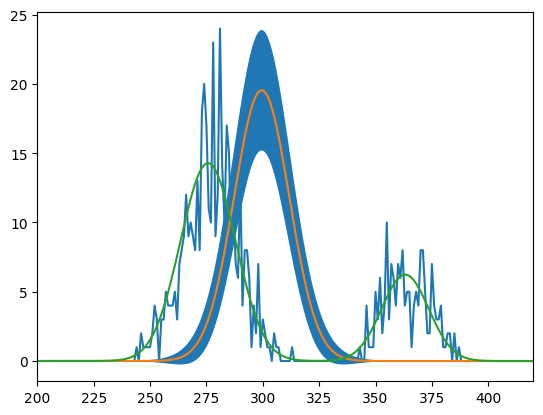

In [72]:
import matplotlib.pyplot as plt

# test of model on task instance
N_value = 600   #CHANGE THIS
clique_size_fraction = 0.27 # CHANGE THIS
print("Clique size of: ", int(clique_size_fraction*N_value), " in a graph of size: ", N_value)
# visualizing input for 15 graphs, "p_reduce"
graphs_with_clique = graphs_gen.generate_batch(15, N_value, np.repeat([int(clique_size_fraction*N_value)],15), "p_reduce", False, p_clique=1)
# Show 15 graphs
fig, axes = plt.subplots(3, 5, figsize=(7, 4))
for i in range(15):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(np.squeeze(graphs_with_clique[0][i]), cmap='gray_r')
    axes[row, col].axis('off')
plt.show()
# testing ideal MLP on this graph:
ideal_MLP = Ideal_MLP(N_value)
soft_output = ideal_MLP(graphs_with_clique[0])
hard_output = (soft_output >= 0.5).long().cpu().numpy()  # threshold at 0.5

print("Soft outputs:", soft_output)
print("Hard outputs: ", hard_output)
print("Labels: ", graphs_with_clique[1])

print("Fraction of correct responses:")
print(np.sum(hard_output == graphs_with_clique[1]) / 15)

# Test function

In [38]:
# read configuration file:
config = load_config(
    os.path.join("Ideal-MLP_test_config.yml")
)  # CHANGE THIS TO PERFORM DIFFERENT EXPERIMENTS

# looping over the different graph sizes in the experiment:
for graph_size in config["graph_size_values"]:
    
    ideal_MLP = Ideal_MLP(graph_size).to(device)

    # Create empty dictionaries for storing testing results:
    fraction_correct_results = {}  # Fraction correct for each clique size
    metrics_results_list = []

    # Calculate max clique size for testing (proportion of graph size):
    max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"]
    max_clique_size = int(
        max_clique_size_proportion_test * graph_size
    )

    # Calculate array of clique sizes for all test curriculum
    # NOTE: if max clique size is smaller than the the number of test levels, use max clique size as the number of test levels
    clique_sizes = np.linspace(
        max_clique_size,
        1,
        num=min(max_clique_size, config["testing_parameters"]["clique_testing_levels"]),
    ).astype(int)
    
    # Metrics initialization
    TP, FP, TN, FN = 0, 0, 0, 0  
    y_scores = []
    y_true = []    

    # Loop for decreasing clique sizes
    for current_clique_size in clique_sizes:

        # Initialize fraction correct list, updated at each test iteration
        fraction_correct_list = []

        # Loop for testing iterations:
        for test_iter in range(config["testing_parameters"]["test_iterations"]):

            # Generate clique size value of each graph in the current batch
            clique_size_array_test = graphs_gen.generate_batch_clique_sizes(
                np.array([current_clique_size]),
                config["testing_parameters"]["num_test"],
            )

            # Generate validation graphs
            test = graphs_gen.generate_batch(
                config["testing_parameters"]["num_test"],
                graph_size,
                clique_size_array_test,
                config["p_correction_type"],
                False,
            )
            
            # Perform prediction on test data
            soft_output = ideal_MLP(test[0]).squeeze()
            hard_output = (soft_output >= 0.5).int().cpu().numpy()  # converting to hard output (0/1)
            # print(hard_output.shape, test_labels.shape)   # DEBUGGING

            # Update global metrics for AUC-ROC
            y_scores.extend(soft_output.cpu().tolist())
            labels = test[1]
            y_true.extend(list(labels))
             
            # transforming hard_output and test_labels to torch tensors:
            hard_output = torch.tensor(hard_output, dtype=torch.float32)
            test_labels = torch.tensor(test[1], dtype=torch.float32)
            
            # DEBUGGING:
            print("Soft outputs: ", soft_output)
            print("Hard outputs: ", hard_output)
            print("Test labels: ", test_labels)
            
            # Compute metrics
            TP += ((hard_output == 1) & (test_labels == 1)).sum().item()
            FP += ((hard_output == 1) & (test_labels == 0)).sum().item()
            TN += ((hard_output == 0) & (test_labels == 0)).sum().item()
            FN += ((hard_output == 0) & (test_labels == 1)).sum().item()

            # updating fraction correct list with the accuracy of the current test iteration:
            fraction_correct_list.append(
                (hard_output == test_labels).sum().item()
                / (1.0 * config["testing_parameters"]["num_test"])
            )
            
            # delete unused variables
            del test, hard_output, test_labels, clique_size_array_test, soft_output
            torch.cuda.empty_cache()

        # Updating dictionary after all test iterations for current clique size have been completed:
        fraction_correct_results[current_clique_size] = round(
            sum(fraction_correct_list) / len(fraction_correct_list), 2
        )

        # Printing the size of the clique just tested and the corresponding test accuracy:
        print(
            f"||| Completed testing for clique = {current_clique_size}. "
            f"Average fraction correct = {fraction_correct_results[current_clique_size]}"
        )
        print("|||===========================================================")

    # - notify completion of testing:
    print(f"| Finished testing Ideal MLP at N = {graph_size}.")

    # Computing metrics:
    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)
    F1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    AUC_ROC = roc_auc_score(y_true, y_scores)
    num_params = sum(
        p.numel() for p in ideal_MLP.parameters()
    )  # storing total number of parameters
    metrics_results = {
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN,
        "precision": precision,
        "recall": recall,
        "F1": F1,
        "AUC_ROC": AUC_ROC,
        "total_params": num_params,
    }

    # Saving accuracy results in .csv file:
    # - defining file name and path:
    file_path = os.path.join(
        os.getcwd(), "results", f"Ideal-MLP_N{graph_size}_fraction_correct_1.csv"
    )
    # - saving the dictionary as a .csv file:
    with open(file_path, "w") as file:
        writer = csv.writer(file)
        writer.writerow(["clique size", "fraction correct"])  # Add column labels
        for key, value in fraction_correct_results.items():
            writer.writerow([key, value])
    # Saving metrics results in .csv file:
    # - defining file name and path:
    file_path = os.path.join(
        os.getcwd(), "results", f"Ideal-MLP_N{graph_size}_metrics_1.csv"
    )
    # - saving the dictionary as a .csv file:
    pd.DataFrame([metrics_results]).to_csv(file_path, index=False)

    print(f"- Ideal MLP Results saved successfully for N = {graph_size}.")

Configuration file loaded successfully.
Precomputing variables...
Completed precomputing variables...
mean diff clique:  tensor([1.7938, 1.7900, 1.8115, 1.1287, 1.1151, 1.8122, 1.1212, 1.0994, 1.1367,
        1.2102, 1.1273, 1.1568, 1.7844, 1.1595, 1.7988, 1.1401, 1.7939, 1.2280,
        1.7913, 1.8106, 1.1343, 1.7999, 1.1467, 1.1416, 1.1500, 1.8025, 1.7989,
        1.8001, 1.7932, 1.1600, 1.1111, 1.1013])
mean diff no clique:  tensor([1.9801, 1.9801, 1.9801, 0.3992, 0.3334, 1.9801, 0.3513, 0.2539, 0.3277,
        0.5052, 0.3127, 0.3786, 1.9801, 0.3605, 1.9801, 0.3950, 1.9801, 0.5493,
        1.9801, 1.9801, 0.4298, 1.9801, 0.3388, 0.2928, 0.4561, 1.9801, 1.9801,
        1.9801, 1.9801, 0.3576, 0.3440, 0.3978])
logits:  tensor([ 0.1863,  0.1901,  0.1686, -0.7295, -0.7817,  0.1679, -0.7700, -0.8456,
        -0.8090, -0.7050, -0.8146, -0.7782,  0.1957, -0.7990,  0.1812, -0.7450,
         0.1862, -0.6787,  0.1888,  0.1694, -0.7046,  0.1802, -0.8079, -0.8488,
        -0.6939,  0.1776,  0.1

C:\Users\danie\AppData\Local\Temp\ipykernel_21664\1197703214.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))


tensor([0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0.])
mean diff clique:  tensor([1.6847, 1.6782, 1.6663, 1.1715, 1.1929, 1.1527, 1.6790, 1.1221, 1.1335,
        1.0821, 1.1446, 1.6783, 1.1644, 1.6619, 1.1264, 1.1033, 1.1591, 1.1799,
        1.1584, 1.1252, 1.6628, 1.1482, 1.6640, 1.1143, 1.6602, 1.6695, 1.1366,
        1.1365, 1.1675, 1.1606, 1.2148, 1.1295])
mean diff no clique:  tensor([1.9796, 1.9796, 1.9796, 0.4146, 0.4619, 0.3774, 1.9796, 0.3328, 0.3507,
        0.3143, 0.3888, 1.9796, 0.4394, 1.9796, 0.2616, 0.3303, 0.3731, 0.4135,
        0.4269, 0.3396, 1.9796, 0.3410, 1.9796, 0.3455, 1.9796, 1.9796, 0.3164,
        0.3913, 0.3971, 0.3632, 0.4418, 0.3812])
logits:  tensor([ 0.2949,  0.3014,  0.3134, -0.7570, -0.7310, -0.7753,  0.3007, -0.7893,
        -0.7828, -0.7679, -0.7558,  0.3013, -0.7250,  0.3178, -0.8648, -0.7729,
        -0.7859, -0.7664, -0.7314, -0.7856,  0.3169, -0.8072,  0.31